In [29]:
from pynq import PL
from pynq import allocate
PL.reset()
from pynq import Overlay
import numpy as np
ol = Overlay('design_1.bit')

dma = ol.axi_dma_0
inter = ol.interface_0

inter.write(0, 6) # number frames
inter.write(4, 1000) # max corners
inter.write(8, 40) # max distance
inter.write(12, 4) # ratio_p
inter.write(16, 5) # ratio_q

buffer = allocate(shape=(1000,), dtype=np.uint64)
dma.recvchannel.transfer(buffer)
dma.recvchannel.wait()

print(buffer)

[ 792655887579811840  792655887580854272  801663088982040576
  801663088983080960  810670290384259072  810670290385301504
  819950172879495168  819950172880521216  819950172881598464
  838056934683756544  847042145848164352  847068534134609920
  847244456035909632  847248854083469312  847248854084538368
  856260453534330880  865280846929655808  870202262156292096
  865272052983040000  865276451030611968  865280849078161408
  874222079766972416  874226477814542336  883229281169215488
  883233679216766976  897175487838752768  892254074761668608
  892258472809236480  892271666951901184  892276064999475200
  892311249379948544  892311249380993024  900944616740683776
  901322848829753344  915189890643185664  915189892789616640
  919412018425931776  919412018427000832  928357647180158976
  946248904651909120  955352860952963072  946372049982535680
  946372049983545344  946512787505442816  946512787506493440
  946517185554049024  955519988907671552  955524386955231232
  955524386956267520  96

In [8]:
buffer = allocate(shape=(1000,), dtype=np.uint64)

dma.recvchannel.transfer(buffer)
dma.recvchannel.wait()

padding = buffer & 0x7FF
dist = (buffer >> 11) & 0x1FF
x_curr = (buffer >> 20) & 0x7FF
y_curr = (buffer >> 31) & 0x7FF
x_prev = (buffer >> 42) & 0x7FF
y_prev = (buffer >> 53) & 0x7FF

valid = (dist > 0)

x_curr = x_curr[valid]
y_curr = y_curr[valid]
x_prev = x_prev[valid]
y_prev = y_prev[valid]
dist = dist[valid]

print(len(x_curr))
for i in range(len(x_curr)):
    if x_curr[i] != x_prev[i]:
        print("x val differences", x_curr[i], x_prev[i])
    else:
        print("x val same       ", x_curr[i], x_prev[i])
    if y_curr[i] != y_prev[i]:
        print("y val differences", y_curr[i], y_prev[i])
    else: 
        print("y val same       ", y_curr[i], y_prev[i])

724
x val differences 19 135
y val differences 71 90
x val differences 19 135
y val differences 72 90
x val differences 129 135
y val differences 86 89
x val differences 130 136
y val differences 86 89
x val differences 131 136
y val differences 86 89
x val differences 130 136
y val differences 87 90
x val differences 143 148
y val differences 94 97
x val differences 113 119
y val differences 98 101
x val differences 174 180
y val differences 101 104
x val differences 175 181
y val differences 101 104
x val differences 174 180
y val differences 102 105
x val differences 175 181
y val differences 102 105
x val same        19 19
y val differences 105 96
x val same        8 8
y val differences 106 112
x val same        7 7
y val differences 107 111
x val same        8 8
y val differences 107 72
x val differences 34 42
y val differences 107 110
x val differences 35 42
y val differences 107 110
x val differences 163 169
y val differences 108 111
x val differences 164 169
y val differences 1

In [8]:
def read_frame_match():
    buffer = allocate(shape=(1000,), dtype=np.uint64)
    dma.recvchannel.transfer(buffer)
    dma.recvchannel.wait()

    padding = buffer & 0x7FF
    dist = (buffer >> 11) & 0x1FF
    x_curr = (buffer >> 20) & 0x7FF
    y_curr = (buffer >> 31) & 0x7FF
    x_prev = (buffer >> 42) & 0x7FF
    y_prev = (buffer >> 53) & 0x7FF

    valid = (dist > 0)

    x_curr = x_curr[valid]
    y_curr = y_curr[valid]
    x_prev = x_prev[valid]
    y_prev = y_prev[valid]
    dist = dist[valid]
    
    return x_prev, y_prev, x_curr, y_curr

In [9]:
import numpy as np
import random


def fit_fundamental_matrix(sample_corners1, sample_corners2):
    #return fit_fundamental_matrix_ideal(sample_corners1, sample_corners2)
    S = len(sample_corners1) # number of samples

    # create the matrix A to use for solving Af = 0
    matA = []
    for i in range(S):
        x1, y1 = sample_corners1[i]
        x2, y2 = sample_corners2[i]
        matA.append((np.outer(np.array([x2,y2,1], dtype=float), np.array([x1,y1,1], dtype=float))).flatten())

    # solve Af = 0 for f using SVD
    _, _, matVt = np.linalg.svd(matA)
    matF = matVt[-1].reshape(3, 3)

    # force F to have rank 2
    matU, matD, matVt = np.linalg.svd(matF)
    matD[-1] = 0
    matF = matU @ np.diag(matD) @ matVt

    matF /= matF[2,2]

    return matF


def find_inliers(matF, corners1, corners2, matches, threshold):
    inliers = []
    for idx1, idx2, dist in matches:
        x1, y1 = corners1[idx1]
        x2, y2 = corners2[idx2]
        proj = matF @ np.array([[x1],[y1],[1]], dtype=float)
        a = proj[0,0]
        b = proj[1,0]
        c = proj[2,0]
        error = (a*x2 + b*y2 + c)**2 / (a**2+b**2)
        proj2 = np.array([[x2,y2,1]], dtype=float) @ matF
        a = proj2[0,0]
        b = proj2[0,1]
        c = proj2[0,2]
        error = max(error, (a*x1 + b*y1 + c)**2 / (a**2+b**2))
        
        if error < threshold**2:
            inliers.append((idx1,idx2,dist))
    return inliers


def ransac(corners1, corners2, matches, threshold=5, iterations=1000):
    """
    Find the Fundamental Matrix and the inliers correspoonding to it
    
    Args:
        corners1: List of (x,y) for corners in the first frame
        corners2: List of (x,y) for corners in the second frame
        matches: List of (idx1, idx2, distance) tuples
        
    Returns:
        F: Fundamental matrix
        inliers: subset of matches - the inliers corresponding to F
    """
    #TODO: what if len(matches) < 8?

    bestF = None
    best_num_inliers = -1

    for _ in range(iterations):
        # pick 8 random pairs of points from matches
        S = 8 # number of samples
        sample = random.sample(matches, S)
        sample_corners1 = [corners1[idx1] for idx1, _, _ in sample]
        sample_corners2 = [corners2[idx2] for _, idx2, _ in sample]

        # fit the fundamental matrix to samples
        matF = fit_fundamental_matrix(sample_corners1, sample_corners2)

        # find corresponding inliers
        num_inliers = len(find_inliers(matF, corners1, corners2, matches, threshold))

        # if current F is better, update best F so far
        if num_inliers > best_num_inliers:
            best_num_inliers = num_inliers
            bestF = matF
    
    # re-fit the fundamental matrix to all inliers
    inliers = find_inliers(bestF, corners1, corners2, matches, threshold)
    sample_corners1 = [corners1[idx1] for idx1, _, _ in inliers]
    sample_corners2 = [corners2[idx2] for _, idx2, _ in inliers]
    bestF = fit_fundamental_matrix(sample_corners1, sample_corners2)

    # recompute inliers
    inliers = find_inliers(bestF, corners1, corners2, matches, threshold)

    return bestF, inliers


<IPython.core.display.Javascript object>


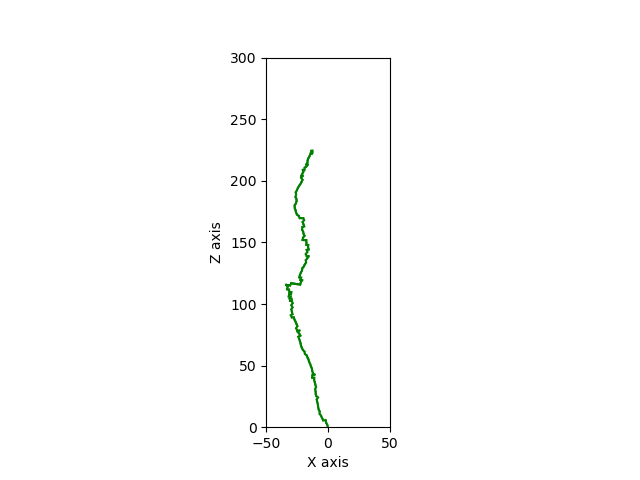

In [30]:
%matplotlib notebook
import numpy as np
import cv2
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import time



WORKLOAD = 5
MAX_IMG = 300
SLEEP_TIME = 0.2
APPLY_MUL = 2





def RANSAC_ideal(src_pts, dst_pts):
    F, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.FM_RANSAC, 5)
    
    if mask is None:
        return None, None

    ransac_matches = []
    for i, present in enumerate(mask):
        if present:
            ransac_matches.append(i)

    return F, ransac_matches


def RANSAC_my(src_pts, dst_pts):
    _matches = [(i, i, 0) for i in len(src_pts)]
    F, inliers = ransac(src_pts, dst_pts, _matches)

    ransac_matches = [cv2.DMatch(_queryIdx=q, _trainIdx=t, _imgIdx=0, _distance=d) for (q, t, d) in inliers]

    return F, ransac_matches








with open(f"img/KITTI_sequence_{WORKLOAD}/calib.txt", 'r') as f:
    K = np.fromstring(f.readline(), dtype=np.float64, sep=' ').reshape((3,4))[0:3,0:3]
    P1 = np.fromstring(f.readline(), dtype=np.float64, sep=' ').reshape((3,4))

R_cur = np.eye(3, dtype=np.float64)
t_cur = np.zeros(3, dtype=np.float64)

camera_pos = [np.zeros(3)]



fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot()
ax.set_xlabel('X axis')
ax.set_ylabel('Z axis')
#ax.set_zlabel('Z axis')
ax.set_xlim(-50,50)
ax.set_ylim(0,300)
ax.set_aspect('equal')
#ax.view_init(elev=0, azim=-90)
#plt.ion()
#plt.show()



for i in range(MAX_IMG):
    sleep_time = SLEEP_TIME
    start = time.perf_counter()
#     corners1, corners2, matches = ORB_ideal(images[i], images[i+1])
#     points1 = np.float32([corners1[m.queryIdx].pt for m in matches])
#     points2 = np.float32([corners2[m.trainIdx].pt for m in matches])
    x_prev, y_prev, x_curr, y_curr = read_frame_match()
#     print(len(x_prev))
    points1 = np.float32(np.column_stack((x_prev,y_prev)))
    points2 = np.float32(np.column_stack((x_curr,y_curr)))
    
    F, matches_ransac = RANSAC_ideal(points1, points2)
    points1 = points1[matches_ransac]
    points2 = points2[matches_ransac]
    if F is None:
        sleep_time += start-time.perf_counter()
        if (sleep_time > 0):
            time.sleep(sleep_time)
        continue
    E = K.T @ F @ K

    _, R, t, mask_pose = cv2.recoverPose(E, points1, points2, K)
    if np.trace(R) < 1 or t[2,0] > 0: # check rotation is <90deg
    #if t[2,0] > 0:
        sleep_time += start-time.perf_counter()
        if (sleep_time > 0):
            time.sleep(sleep_time)
        continue

    for _ in range(APPLY_MUL):
        R_cur = R_cur @ R.T
        t_cur = t_cur - (R_cur @ np.ndarray.flatten(t))

    camera_pos.append(t_cur)
    
    
    
    p1 = camera_pos[-2]
    p2 = camera_pos[-1]
    #print(np.round(p2, 3).tolist())
    ax.plot(
        [p1[0], p2[0]],
        #[p1[1], p2[1]],
        [p1[2], p2[2]],
        c='g'
    )
    fig.canvas.draw()
    fig.canvas.flush_events()
    sleep_time += start-time.perf_counter()
    if (sleep_time > 0):
        time.sleep(sleep_time)
#     else:
#         print("Too much time")
